In [1]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import os
import time

In [2]:
# Function to evaluate the entropy of a vector
# INPUTS
# - v: vector that contains in each cell the value of a byte (so from 0 to 255)
# - num: number of cells of the vector we want to consider in the analysis (from the first element)
# OUTPUT: entropy value
def entropy(v, num):
    freq = np.zeros(256)
    for i in range(num):
        freq[int(v[i])]=freq[int(v[i])]+1
    h = 0
    for i in range(256):
        if freq[i]>0:
            h = h + (freq[i]/num) * np.log2(freq[i]/num)
    h = -h
    return h

# Function to evaluate the entropy of a file as a function of the header lenght
# INPUTS
# - file: the file we want to anlyze (formats as an integer vector)
# - Bytes: total number of bytes we want to consider in the analysis
# OUTPUT: vector that contains the entropy values as a function of the header lenght analyzed

def entropy_analysis(file, Bytes):
    h_vector = np.zeros(int(Bytes/8)+1)
    for i in range(int(Bytes/8)+1):
        h_vector[i] = entropy(file, 8*i)
    return h_vector

# Function to evaluate the Area (DDA approach) between two files 
# INPUTS
# - h_1,h_2: vectors obtained with entropy_analysis function
# OUTPUT: value of the area
def diff_area(h_1,h_2):
    area = 0
    length = min(len(h_1),len(h_2))
    diff_vec = np.zeros(length)
    for i in range(length):
        diff_vec[i]=abs(h_1[i]-h_2[i])
    sum = 0
    for i in range(2,length-2):
        sum = sum+2*diff_vec[i]
    area = (8/2)*(diff_vec[1]+diff_vec[len(h_1)-1]+sum)
    return area

# Function to transform the file of the dataset in a vector ready to be analyzed
# INPUTS
# - file: the file from the dataset we want to analyze
# - size: the size of the file we want to cut
# OUTPUT: file vector
def file_to_vector(file, start, offset):
    vec = np.zeros(offset)
    for i in range(offset):
        vec[i] = int.from_bytes(bytes(file[start + i], 'latin-1'), byteorder="big")
    return vec

# Return a vector containing ones, if for different header lengths correctly classify a file, and 0.0 otherwise. y is the correct result (True or False),
def accuracies(threshold, areas, offset, y):
    accuracies = np.zeros([int(offset/8),1], dtype=float)
    errors = np.zeros([int(offset/8),1], dtype=float)
    for i in range(len(areas)):
        # True negatives
        if y==False and areas[i] > threshold:
            accuracies[i] = 1.0
        # True positives
        if y==True and areas[i] <= threshold:
            accuracies[i] = 1.0
        # False negatives
        if y==True and areas[i] > threshold:
            errors[i] = 1.0
        # False positives
        if y==False and areas[i] <= threshold:
            errors[i] = 1.0
    return accuracies, errors

#analyze the differential area of file_vector from the byte at position start to the byte at position end
def trapezoidal_rule(ideal_file, file_vector, offset):
    area = np.zeros(int(offset/8))
    # Iterate over the different header lenghts of the file
    for i in range(8, offset + 1, 8):
        h_ideal = entropy_analysis(ideal_file, i)
        h = entropy_analysis(file_vector, i)
        area[int(i/8)-1] = diff_area(h_ideal,h)
    return area

Now we set all the parameters of our detection mechanism

In [3]:
offset = 256

ideal_file = np.zeros(offset)
for i in range(offset):
    ideal_file[i]=randint(0,255)

# Obtains all paths to analyze from a .txt files
#f = open('./paths.txt', 'r')
f = open('./paths/mixed_dataset.txt', 'r')
paths = f.readlines()
f.close()
thresholds = np.arange(2,35,1)
distances = np.arange(15,39,3)
files_analyzed = 0

true_positives = np.zeros([len(thresholds), len(distances), int(offset/8), 1], dtype = float)
true_negatives = np.zeros([len(thresholds), len(distances), int(offset/8), 1], dtype = float)
false_positives = np.zeros([len(thresholds), len(distances), int(offset/8), 1], dtype = float)
false_negatives = np.zeros([len(thresholds), len(distances), int(offset/8), 1], dtype = float)
acc = np.zeros([len(thresholds), len(distances), int(offset/8), 1], dtype = float)

In [4]:
start_time = time.time()

# Iterate over the different directories containing files to analyze
for j in range(len(paths)):
    # List all the files in the paths[j] directory
    files=os.listdir(paths[j][:-1])
    print("Start analysizng the directory", paths[j][:-1])
    # Iterate over the different files in the directory paths[j]
    for object in files:
        areas = []
        full_path = paths[j][:-1] + "/" + object
        f=open(full_path, "r", encoding='latin-1')
        file = f.read()
        if len(file) >= 2*offset:
            best_area = np.zeros([len(distances), int(offset/8)], dtype = float)
            file_vector = file_to_vector(file, 0, offset)
            areas.append(trapezoidal_rule(ideal_file, file_vector, offset))
            # Second fragment
            start = randint(offset, len(file) - offset)                
            file_vector = file_to_vector(file, start, offset)
            areas.append(trapezoidal_rule(ideal_file, file_vector, offset))
            
            for k in range(len(areas[0])):
                for d in range(len(distances)):
                    if areas[0][k] > areas[1][k] and areas[0][k] - distances[d] < areas[1][k]:
                        best_area[d][k] = areas[0][k]
                    else:
                        best_area[d][k] = min(areas[0][k], areas[1][k])
            # Iterate over different threshold values
            for i in range(len(thresholds)):
                for d in range(len(distances)):
                    if paths[j][19:24] == "EXTRA":
                        results = accuracies(thresholds[i], best_area[d], offset, True)
                        acc[i][d] = np.add(acc[i][d], results[0], dtype=float)
                        true_positives[i][d] = np.add(true_positives[i][d], results[0], dtype=float)
                        false_negatives[i][d] = np.add(false_negatives[i][d], results[1], dtype=float)
                    else:
                        results = accuracies(thresholds[i], best_area[d], offset, False)
                        acc[i][d] = np.add(acc[i][d], results[0], dtype=float)
                        true_negatives[i][d] = np.add(true_negatives[i][d], results[0], dtype=float)
                        false_positives[i][d] = np.add(false_positives[i][d], results[1], dtype=float)
            files_analyzed += 1
        f.close()

acc = np.multiply(np.true_divide(acc, float(files_analyzed)), 100.0, dtype=float)

time_spent = time.time() - start_time
print("Time for the analysis of the dataset")
print("--- %s minutes, %s seconds, %s files analyzed ---" % (time_spent//60, ((time_spent)-60*((time_spent)//60))//1, files_analyzed))

Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-repeat-ciphertext
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny-repeat-ciphertext
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny-repeat-ciphertext
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny-repeat-ciphertext
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-PHOBOS-tiny-repeat-ciphertext
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-RYUK-tiny-repeat-ciphertext
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-SODINOKIBI-tiny-repeat-ciphertext
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-low-entropy-bytes
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny-low-entropy-bytes
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny-low-entropy-bytes
Start analysizng the dir

In [5]:
# RUN CAREFULLY, YOU MAY OVERWRITE A PREVIOUSLY STORED TENSOR RELEVANT FOR THE EXPERIMENT!
# Save the tensor in the file accuracies.npy so we can recover it even without running another time the previous code
acc_reshaped = acc.reshape(np.shape(acc)[0]*np.shape(acc)[1],np.shape(acc)[2])
np.save("./results/acc_2F_mix.npy", acc_reshaped, fix_imports=False)

true_negatives_reshaped = true_negatives.reshape(np.shape(true_negatives)[0]*np.shape(true_negatives)[1],np.shape(true_negatives)[2])
np.save("./results/TN_2F_mix.npy", true_negatives_reshaped, fix_imports=False)

true_positives_reshaped = true_positives.reshape(np.shape(true_positives)[0]*np.shape(true_positives)[1],np.shape(true_positives)[2])
np.save("./results/TP_2F_mix.npy", true_positives_reshaped, fix_imports=False)

false_negatives_reshaped = false_negatives.reshape(np.shape(false_negatives)[0]*np.shape(false_negatives)[1],np.shape(false_negatives)[2])
np.save("./results/FN_2F_mix.npy", false_negatives_reshaped, fix_imports=False)

false_positives_reshaped = false_positives.reshape(np.shape(false_positives)[0]*np.shape(false_positives)[1],np.shape(false_positives)[2])
np.save("./results/FP_2F_mix.npy", false_positives_reshaped, fix_imports=False)

In [6]:
# deserialize the tensor from the file .npy
acc_des=np.load('./results/acc_2F_mix.npy')
acc_des = acc_des.reshape(len(thresholds), len(distances), int(offset/8))

TN_des=np.load('./results/TN_2F_mix.npy')
TN_des = TN_des.reshape(len(thresholds), len(distances), int(offset/8))

TP_des=np.load('./results/TP_2F_mix.npy')
TP_des = TP_des.reshape(len(thresholds), len(distances), int(offset/8))

FN_des=np.load('./results/FN_2F_mix.npy')
FN_des = FN_des.reshape(len(thresholds), len(distances), int(offset/8))

FP_des=np.load('./results/FP_2F_mix.npy')
FP_des = FP_des.reshape(len(thresholds), len(distances), int(offset/8))

Maximum accuracy obtained for threshold  9, distance 36, header length 48, with value 91.46


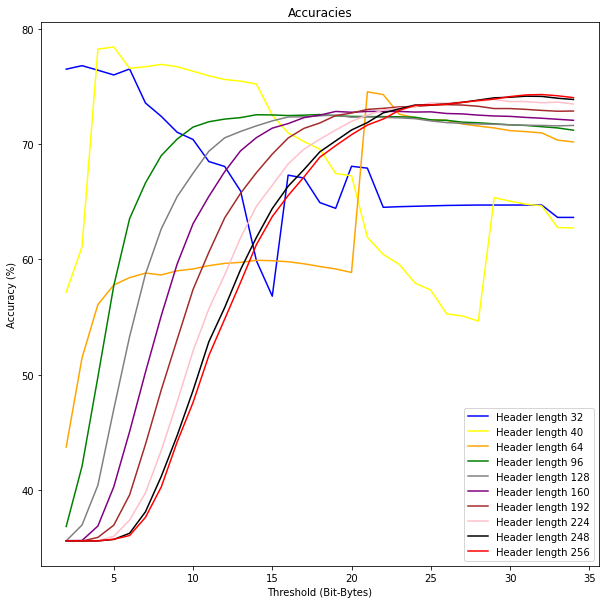

In [7]:
ind = np.unravel_index(np.argmax(acc_des, axis=None), acc_des.shape)
d = ind[1]
print("Maximum accuracy obtained for threshold %2d, distance %2d, header length %2d, with value %3.2f" % (thresholds[ind[0]], distances[ind[1]], 8*(ind[2]+1), acc_des[ind]))

# Accuracy = (TP+TN)/(TP+TN+FP+FN)
hl_thresh = acc_des.transpose()

# Plot of the accuracies obtained using different threshold and different header lengths
plt.figure(figsize=(10,10))
plt.title("Accuracies")
plt.xlabel("Threshold (Bit-Bytes)")
plt.ylabel("Accuracy (%)")
plt.plot(thresholds, hl_thresh[3][d], color="blue", label="Header length 32")
plt.plot(thresholds, hl_thresh[4][d], color="yellow", label="Header length 40")
plt.plot(thresholds, hl_thresh[7][d], color="orange", label="Header length 64")
plt.plot(thresholds, hl_thresh[11][d], color="green", label="Header length 96")
plt.plot(thresholds, hl_thresh[15][d], color="grey", label="Header length 128")
plt.plot(thresholds, hl_thresh[19][d], color="purple", label="Header length 160")
plt.plot(thresholds, hl_thresh[23][d], color="brown", label="Header length 192")
plt.plot(thresholds, hl_thresh[27][d], color="pink", label="Header length 224")
plt.plot(thresholds, hl_thresh[30][d], color="black", label="Header length 248")
plt.plot(thresholds, hl_thresh[31][d], color="red", label="Header length 256")
plt.legend()
plt.savefig('./Img/acc_2F_mix.jpg')
plt.show()

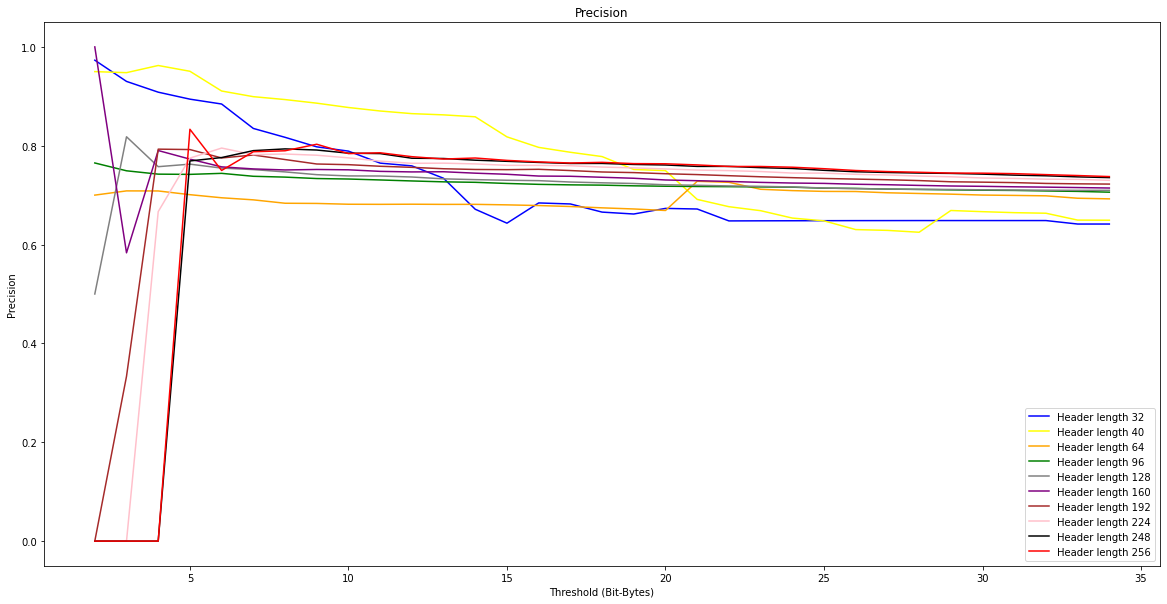

Precision = 0.9194


In [8]:
#Precision = TP/TP+FP

# Get for each threshold and header length the precision
prec= np.zeros([int(offset/8),len(thresholds)])
for i in range(int(offset/8)):
    for j in range(len(thresholds)):
        if ((TP_des[j][d][i]+FP_des[j][d][i]))>0:
            prec[i][j] = TP_des[j][d][i]/(TP_des[j][d][i]+FP_des[j][d][i])

# Plot of the precision obtained using different threshold and different header lengths
plt.figure(figsize=(20,10))
plt.title("Precision")
plt.xlabel("Threshold (Bit-Bytes)")
plt.ylabel("Precision")
plt.plot(thresholds, prec[3], color="blue", label="Header length 32")
plt.plot(thresholds, prec[4], color="yellow", label="Header length 40")
plt.plot(thresholds, prec[7], color="orange", label="Header length 64")
plt.plot(thresholds, prec[11], color="green", label="Header length 96")
plt.plot(thresholds, prec[15], color="grey", label="Header length 128")
plt.plot(thresholds, prec[19], color="purple", label="Header length 160")
plt.plot(thresholds, prec[23], color="brown", label="Header length 192")
plt.plot(thresholds, prec[27], color="pink", label="Header length 224")
plt.plot(thresholds, prec[30], color="black", label="Header length 248")
plt.plot(thresholds, prec[31], color="red", label="Header length 256")
plt.legend()
plt.show()

print("Precision = %3.4f"  % (prec[ind[2]][ind[0]]))

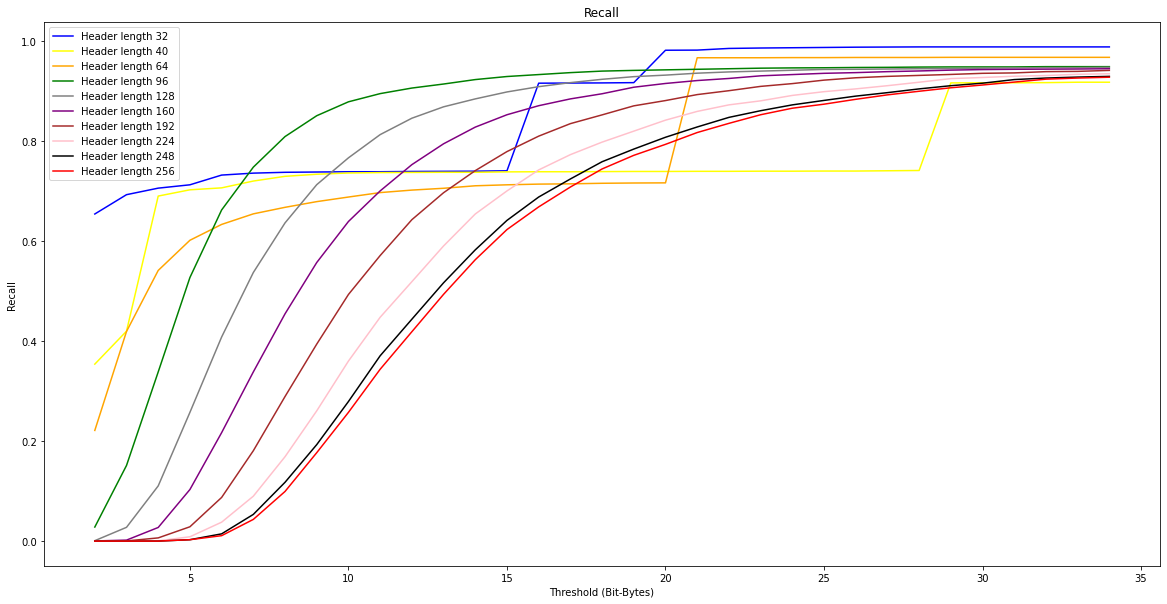

Recall = 0.9508


In [9]:
# Recall = TP/TP+FN

# Get for each threshold and header length the recall
rec= np.zeros([int(offset/8),len(thresholds)])
for i in range(int(offset/8)):
    for j in range(len(thresholds)):
        if ((TP_des[j][d][i]+FN_des[j][d][i]))>0:
            rec[i][j] = TP_des[j][d][i]/(TP_des[j][d][i]+FN_des[j][d][i])

# Plot of the recall obtained using different threshold and different header lengths
plt.figure(figsize=(20,10))
plt.title("Recall")
plt.xlabel("Threshold (Bit-Bytes)")
plt.ylabel("Recall")
plt.plot(thresholds, rec[3], color="blue", label="Header length 32")
plt.plot(thresholds, rec[4], color="yellow", label="Header length 40")
plt.plot(thresholds, rec[7], color="orange", label="Header length 64")
plt.plot(thresholds, rec[11], color="green", label="Header length 96")
plt.plot(thresholds, rec[15], color="grey", label="Header length 128")
plt.plot(thresholds, rec[19], color="purple", label="Header length 160")
plt.plot(thresholds, rec[23], color="brown", label="Header length 192")
plt.plot(thresholds, rec[27], color="pink", label="Header length 224")
plt.plot(thresholds, rec[30], color="black", label="Header length 248")
plt.plot(thresholds, rec[31], color="red", label="Header length 256")
plt.legend()
plt.show()

print("Recall = %3.4f"  % (rec[ind[2]][ind[0]]))

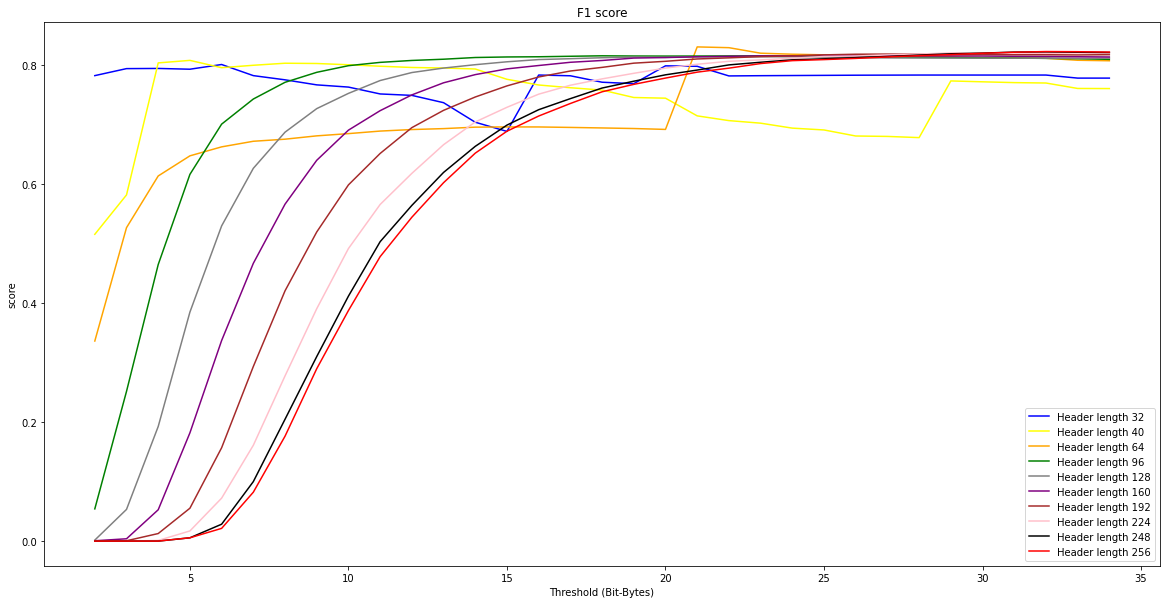

F1 score = 0.9349


In [11]:
# F1 score = 2*(Recall * Precision) / (Recall + Precision)

# Get for each threshold and header length the f1 score
f1= np.zeros([int(offset/8),len(thresholds)])
for i in range(int(offset/8)):
    for j in range(len(thresholds)):
        if ((TP_des[j][d][i]+FN_des[j][d][i])>0) and ((TP_des[j][d][i]+FP_des[j][d][i])>0):
            precision= TP_des[j][d][i]/(TP_des[j][d][i]+FP_des[j][d][i])
            recall= TP_des[j][d][i]/(TP_des[j][d][i]+FN_des[j][d][i])
            if recall + precision != 0.0:
                f1[i][j] = 2*(recall*precision)/(recall+precision)
            else:
                f1[i][j] = 0.0
            
# Plot of the f1 score obtained using different threshold and different header lengths
plt.figure(figsize=(20,10))
plt.title("F1 score")
plt.xlabel("Threshold (Bit-Bytes)")
plt.ylabel("score")
plt.plot(thresholds, f1[3], color="blue", label="Header length 32")
plt.plot(thresholds, f1[4], color="yellow", label="Header length 40")
plt.plot(thresholds, f1[7], color="orange", label="Header length 64")
plt.plot(thresholds, f1[11], color="green", label="Header length 96")
plt.plot(thresholds, f1[15], color="grey", label="Header length 128")
plt.plot(thresholds, f1[19], color="purple", label="Header length 160")
plt.plot(thresholds, f1[23], color="brown", label="Header length 192")
plt.plot(thresholds, f1[27], color="pink", label="Header length 224")
plt.plot(thresholds, f1[30], color="black", label="Header length 248")
plt.plot(thresholds, f1[31], color="red", label="Header length 256")
plt.legend()
plt.show()

print("F1 score = %3.4f"  % (f1[ind[2]][ind[0]]))